In [112]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import optuna
import pickle
import joblib
import mlflow
import mlflow.sklearn
import warnings
warnings.filterwarnings('ignore')

In [113]:
# Cargar los datos
df = pd.read_csv('stroke_dataset.csv')

In [114]:
# Define las columnas
cat_cols = ['gender', 'ever_married', 'Residence_type', 'work_type', 'smoking_status']  # Todas las variables categóricas
num_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']  # Variables numéricas

# Preprocesamiento simplificado usando OrdinalEncoder
preprocessor = ColumnTransformer(
    transformers=[
        # Escalar las variables numéricas
        ('num', StandardScaler(), num_cols),
        
        # Aplicar OrdinalEncoder a todas las variables categóricas
        ('cat', OrdinalEncoder(), cat_cols)
    ]
)


In [115]:
# Separar características y objetivo
X = df[cat_cols + num_cols]
y = df['stroke']

In [116]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
# Función para crear el pipeline con SMOTE
def create_pipeline(classifier):
    return ImbPipeline([
        ('preprocessor', preprocessor), # preprocesamiento
        ('smote', SMOTE(random_state=42)), # Synthetic Minority Over-sampling Technique
        ('classifier', classifier) # clasificador
    ])

In [118]:
# Función para evaluar el modelo
def evaluate_model(y_true, y_pred, y_pred_proba):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_pred_proba)
    }

In [119]:
# Diccionario de modelos
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

In [120]:
# Entrenar y evaluar modelos
results = {}
best_model = None
best_auc = 0

for name, model in models.items():
    pipeline = create_pipeline(model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    metrics = evaluate_model(y_test, y_pred, y_pred_proba)
    results[name] = metrics
    
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    if metrics['auc'] > best_auc:
        best_auc = metrics['auc']
        best_model = (name, pipeline)

print(f"\nBest model: {best_model[0]} with AUC = {best_auc:.4f}")


Logistic Regression:
accuracy: 0.7362
precision: 0.1433
recall: 0.7778
f1: 0.2421
auc: 0.8445



Random Forest:
accuracy: 0.9117
precision: 0.0278
recall: 0.0185
f1: 0.0222
auc: 0.7768
[LightGBM] [Info] Number of positive: 3790, number of negative: 3790
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 7580, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

LightGBM:
accuracy: 0.9137
precision: 0.1000
recall: 0.0741
f1: 0.0851
auc: 0.7732

XGBoost:
accuracy: 0.9208
precision: 0.0968
recall: 0.0556
f1: 0.0706
auc: 0.7741

CatBoost:
accuracy: 0.9188
precision: 0.1143
recall: 0.0741
f1: 0.0899
auc: 0.7418

Best model: Logistic Regression with AUC = 0.8445


In [121]:
# Optimización de hiperparámetros con Optuna
def objective(trial):
    if best_model[0] == 'Logistic Regression':
        solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear'])
        
        # Asegurar que la penalización es compatible con el solver
        if solver == 'liblinear':
            penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
        else:
            penalty = 'l2'  # lbfgs solo soporta 'l2' o None
        
        classifier = LogisticRegression(
            C=trial.suggest_loguniform('C', 1e-5, 1e5),
            solver=solver,
            penalty=penalty,
            random_state=42
        )
    elif best_model[0] == 'Random Forest':
        classifier = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 10, 1000),
            max_depth=trial.suggest_int('max_depth', 2, 32),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 20),
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20)
        )
    elif best_model[0] == 'LightGBM':
        classifier = LGBMClassifier(
            num_leaves=trial.suggest_int('num_leaves', 2, 256),
            max_depth=trial.suggest_int('max_depth', 3, 16),
            learning_rate=trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
            n_estimators=trial.suggest_int('n_estimators', 100, 1000)
        )
    elif best_model[0] == 'XGBoost':
        classifier = XGBClassifier(
            max_depth=trial.suggest_int('max_depth', 1, 9),
            learning_rate=trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
            n_estimators=trial.suggest_int('n_estimators', 100, 1000),
            min_child_weight=trial.suggest_int('min_child_weight', 1, 300)
        )
    else:  # CatBoost
        classifier = CatBoostClassifier(
            iterations=trial.suggest_int('iterations', 100, 1000),
            depth=trial.suggest_int('depth', 4, 10),
            learning_rate=trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
            l2_leaf_reg=trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
            verbose=0
        )
    
    pipeline = create_pipeline(classifier)
    
# Configuración de StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    
    for train_index, val_index in skf.split(X_train, y_train):
        # Uso de iloc para obtener las filas correctas
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        pipeline.fit(X_train_fold, y_train_fold)
        y_val_pred_proba = pipeline.predict_proba(X_val_fold)[:, 1]
        
        auc = roc_auc_score(y_val_fold, y_val_pred_proba)
        auc_scores.append(auc)
    
    return np.mean(auc_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-10-20 23:22:27,420] A new study created in memory with name: no-name-15b10b91-c55c-4a88-9925-74bf3c4e66ba
[I 2024-10-20 23:22:27,631] Trial 0 finished with value: 0.8290942497302725 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 5523.402781143778}. Best is trial 0 with value: 0.8290942497302725.
[I 2024-10-20 23:22:27,826] Trial 1 finished with value: 0.8292042771837245 and parameters: {'solver': 'lbfgs', 'C': 0.38268827168697783}. Best is trial 1 with value: 0.8292042771837245.
[I 2024-10-20 23:22:28,034] Trial 2 finished with value: 0.8290942497302725 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 330.2055067269048}. Best is trial 1 with value: 0.8292042771837245.
[I 2024-10-20 23:22:28,244] Trial 3 finished with value: 0.8290942497302725 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1214.343139443721}. Best is trial 1 with value: 0.8292042771837245.
[I 2024-10-20 23:22:28,432] Trial 4 finished with value: 0.8311456029967348 and p

In [122]:
# Entrenar el mejor modelo con los mejores hiperparámetros
best_params = study.best_params
best_classifier = models[best_model[0]]
best_classifier.set_params(**best_params)
best_pipeline = create_pipeline(best_classifier)
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'hypertension',
                                                   'heart_disease',
                                                   'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['gender', 'ever_married',
                                                   'Residence_type',
                                                   'work_type',
                                                   'smoking_status'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(C=0.012670618482180571, penalty='l1',
                                    solver='liblinear'))])

In [123]:
# Evaluar el modelo optimizado
y_pred_optimized = best_pipeline.predict(X_test)
y_pred_proba_optimized = best_pipeline.predict_proba(X_test)[:, 1]
metrics_optimized = evaluate_model(y_test, y_pred_optimized, y_pred_proba_optimized)

print(f"\nBest model after optimization: {best_model[0]}")
print(f"Best parameters: {best_params}")
print("\nOptimized model metrics:")
for metric, value in metrics_optimized.items():
    print(f"{metric}: {value:.4f}")
    
# Calcular e imprimir el overfitting
y_train_pred_proba = best_pipeline.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_train_pred_proba)
overfitting = train_auc - metrics_optimized['auc']
print(f"\nTrain AUC: {train_auc:.4f}")
print(f"Overfitting: {overfitting:.4f}")



Best model after optimization: Logistic Regression
Best parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.012670618482180571}

Optimized model metrics:
accuracy: 0.7222
precision: 0.1438
recall: 0.8333
f1: 0.2452
auc: 0.8464

Train AUC: 0.8410
Overfitting: -0.0054


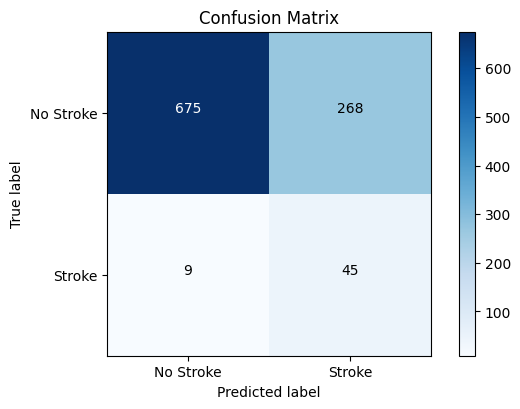

In [124]:
# Visualizar matriz de confusión
cm = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Stroke', 'Stroke'])
plt.yticks(tick_marks, ['No Stroke', 'Stroke'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.show()

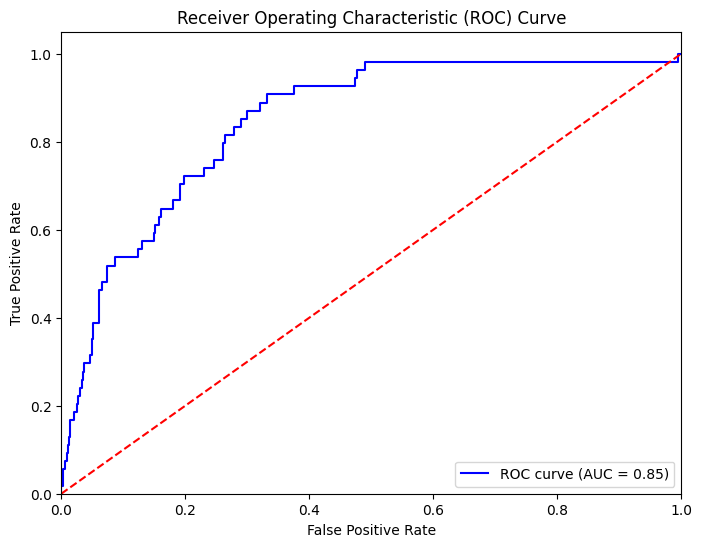

In [125]:
# Visualizar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_optimized)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {metrics_optimized["auc"]:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [126]:
# Guardar el mejor modelo en un archivo pickle
best_model_filename = f'best_stroke_prediction_model_{best_model[0].replace(" ", "_").lower()}.pkl'
joblib.dump(best_pipeline, best_model_filename)
print(f"\nBest model saved as: {best_model_filename}")


Best model saved as: best_stroke_prediction_model_logistic_regression.pkl


In [127]:
# Guardar el preprocesador en un archivo pickle
preprocessor_filename = 'best_stroke_preprocessor.pkl'
joblib.dump(preprocessor, preprocessor_filename)
print(f"Preprocessor saved as: {preprocessor_filename}")

Preprocessor saved as: best_stroke_preprocessor.pkl


In [128]:
# Extraer el clasificador del pipeline
best_classifier = best_pipeline.named_steps['classifier']
X_train_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)  # Transformar X_train

# Inicializar el DataFrame para la importancia
importance_df = pd.DataFrame()

# Calcular la importancia de las características
if hasattr(best_classifier, 'coef_'):  # Modelos lineales
    importance = best_classifier.coef_[0]
    features = best_pipeline.named_steps['preprocessor'].get_feature_names_out(X_train.columns)

elif hasattr(best_classifier, 'feature_importances_'):  # Modelos basados en árboles
    importance = best_classifier.feature_importances_
    features = best_pipeline.named_steps['preprocessor'].get_feature_names_out(X_train.columns)

else:
    raise ValueError("El clasificador no tiene coeficientes ni importancias para calcular.")

# Crear DataFrame de importancia
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df['Importance'] = importance_df['Importance'].abs()
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Mostrar la importancia de las características
print("Importancia de las características:")
print(importance_df)

Importancia de las características:
                  Feature  Importance
0                num__age    1.652735
3  num__avg_glucose_level    0.185697
8          cat__work_type    0.170661
1       num__hypertension    0.089230
9     cat__smoking_status    0.061940
2      num__heart_disease    0.000000
4                num__bmi    0.000000
5             cat__gender    0.000000
6       cat__ever_married    0.000000
7     cat__Residence_type    0.000000


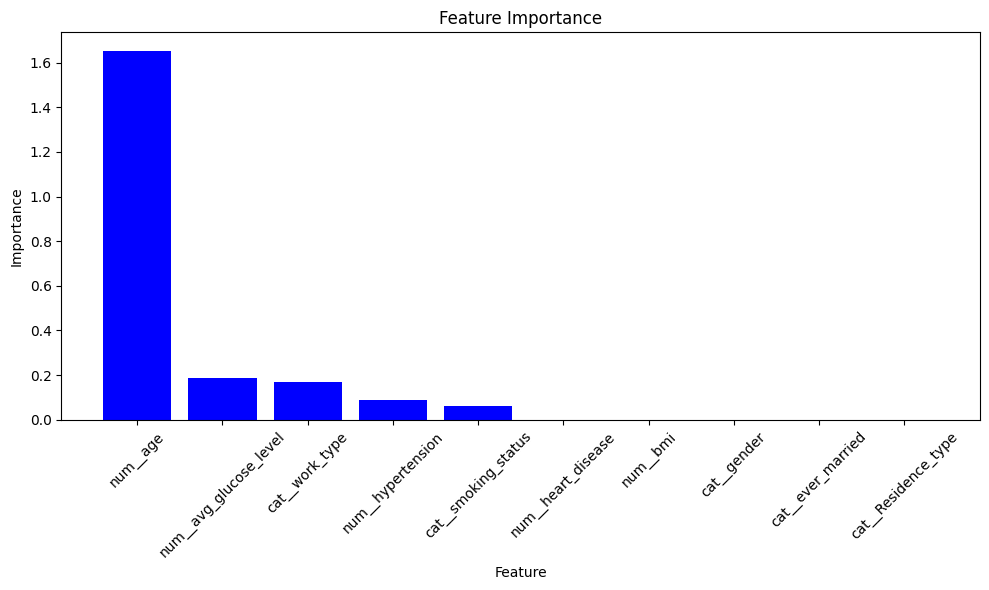

In [129]:
# Hacer una gráfica con la característica de importancias que hemos hecho en el paso anterior
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='blue')
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()